In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import minmax_scale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
import time
import warnings
warnings.filterwarnings('ignore')
# example of grid searching key hyperparametres for KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



In [230]:
df= pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [231]:
df['Transported'].value_counts() # balanced dataset

True     4378
False    4315
Name: Transported, dtype: int64

In [232]:
def showDetails(column):
    print('------------------------------------------')
    print(column +' & TRANSPORTED')
    print(df[column].value_counts())
    tempDict = dict(df[column][df['Transported'] == True].value_counts())
    for i in tempDict.keys():
        tempDict[i] = (tempDict[i]/len(df[df[column] == i]))*100
    print(tempDict)
    print('------------------------------------------')

In [233]:
showDetails('HomePlanet')
showDetails('CryoSleep')
showDetails('Destination')
showDetails('VIP')


------------------------------------------
HomePlanet & TRANSPORTED
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
{'Earth': 42.39461103867884, 'Europa': 65.884561238855, 'Mars': 52.30244457077885}
------------------------------------------
------------------------------------------
CryoSleep & TRANSPORTED
False    5439
True     3037
Name: CryoSleep, dtype: int64
{True: 81.75831412578202, False: 32.892075749218606}
------------------------------------------
------------------------------------------
Destination & TRANSPORTED
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
{'TRAPPIST-1e': 47.11749788672866, '55 Cancri e': 61.0, 'PSO J318.5-22': 50.37688442211056}
------------------------------------------
------------------------------------------
VIP & TRANSPORTED
False    8291
True      199
Name: VIP, dtype: int64
{False: 50.63321674104451, True: 38.19095477386934}
------------------------------------------

Text(0.5, 1.0, 'Group size')

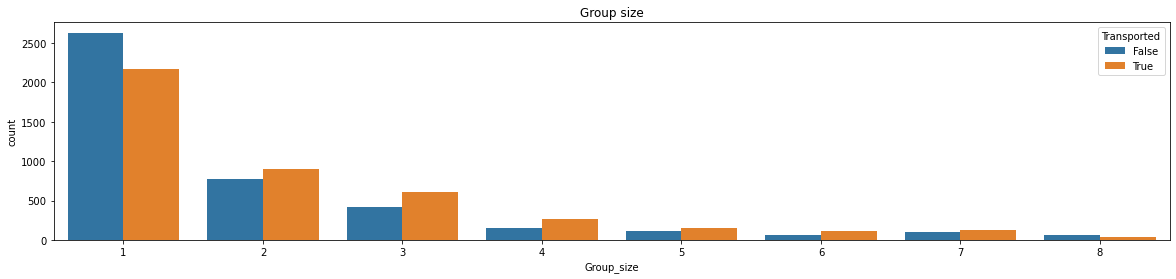

In [234]:
df['Group'] = [x.split('_')[0] for x in list(df['PassengerId'])]
df['Group'] = df['Group'].astype(int)
test_data['Group'] = [x.split('_')[0] for x in list(test_data['PassengerId'])]
test_data['Group'] = test_data['Group'].astype(int)

# New feature - Group size
df['Group_size']=df['Group'].map(lambda x: df['Group'].value_counts()[x])
test_data['Group_size']=test_data['Group'].map(lambda x: test_data['Group'].value_counts()[x])

plt.figure(figsize=(20,4))
sns.countplot(data=df, x='Group_size', hue='Transported')
plt.title('Group size')

In [235]:
def add_traveller_type(df):

    checkdict ={

    }
    newColumnTravellerType = []

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        if df.iloc[index]['Name'] != df.iloc[index]['Name'] :
            lastname = 'NA'
        else :
            lastname =df.iloc[index]['Name'].split(' ')[1]
        if gggg in checkdict:
            checkdict[gggg].append(lastname)
        else :
            checkdict[gggg] = [lastname]

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        lastnames = checkdict[gggg]
        lastname = 'NA'
        if df.iloc[index]['Name'] == df.iloc[index]['Name'] :
            lastname =df.iloc[index]['Name'].split(' ')[1]

        if len(lastnames) == 1:
            newColumnTravellerType.append('INDIVIDUAL')
        elif len(lastnames) > 1:
            if lastname != 'NA' and lastnames.count(lastname) > 1:
                newColumnTravellerType.append('FAMILY')
            else :
                newColumnTravellerType.append('GROUP')

    df['TravellerType'] = newColumnTravellerType
    return df

df=  add_traveller_type(df)
test_data = add_traveller_type(test_data)

In [236]:
# for now deleting the group feature 
# as it was used as a helper to create group size feature

df.drop(columns=['Group','Name'],inplace=True)
test_data.drop(columns=['Group','Name'],inplace=True)

In [237]:
df['Age'].fillna(value=df['Age'].mean(),inplace=True)
df['RoomService'].fillna(value=df['RoomService'].median(),inplace=True)
df['FoodCourt'].fillna(value=df['FoodCourt'].median(),inplace=True)
df['ShoppingMall'].fillna(value=df['ShoppingMall'].median(),inplace=True)
df['Spa'].fillna(value=df['Spa'].median(),inplace=True)
df['VRDeck'].fillna(value=df['VRDeck'].median(),inplace=True)

df.isna().sum()

PassengerId        0
HomePlanet       201
CryoSleep        217
Cabin            199
Destination      182
Age                0
VIP              203
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
Group_size         0
TravellerType      0
dtype: int64

In [238]:
# Custom logic if person is with family than some information 
# should be common like homeplanet destination ect.

def customImputation(column,index):
    if df.iloc[index][column] != df.iloc[index][column]:
        if df.iloc[index]['TravellerType'] == 'FAMILY':
            try:
                if df.iloc[index-1]['TravellerType'] == 'FAMILY' or df.iloc[index+1]['TravellerType'] == 'FAMILY':
                    df.at[index,column] = df.iloc[index-1][column]
                else:
                    df.at[index,column] = df[column].mode().values[0]

            except:
                pass
        else:
            df.at[index,column] = df[column].mode().values[0]
            

columns = ['HomePlanet','CryoSleep','Destination','VIP']
for index in range(len(df)):
    for column in columns:
        customImputation(column,index)
        
        
def customImputation(column,index):
    if test_data.iloc[index][column] != test_data.iloc[index][column]:
        if test_data.iloc[index]['TravellerType'] == 'FAMILY':
            try:
                if test_data.iloc[index-1]['TravellerType'] == 'FAMILY' or test_data.iloc[index+1]['TravellerType'] == 'FAMILY':
                    test_data.at[index,column] = test_data.iloc[index-1][column]
                else:
                    test_data.at[index,column] = test_data[column].mode().values[0]

            except:
                pass
        else:
            test_data.at[index,column] = test_data[column].mode().values[0]
        
for index in range(len(test_data)):
    for column in columns:
        customImputation(column,index)

Text(0.5, 0, '% transported')

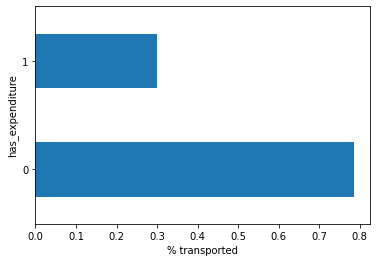

In [239]:
#Get the total amount the passenger expend
df['Expenditure']= df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
test_data['Expenditure']= test_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

df['has_expenditure'] = pd.DataFrame(df['Expenditure'] > 0).astype(int)
test_data['has_expenditure'] = pd.DataFrame(test_data['Expenditure'] > 0).astype(int)

df.groupby('has_expenditure').Transported.mean().plot(kind='barh').set_xlabel('% transported')

In [240]:
#Creates Beans for ages range 
test_data["Age"].min(), test_data["Age"].max()
min_age, max_age = df["Age"].min(), df["Age"].max()
bins = np.linspace(min_age,max_age, 7)
bins
labels = ["0-13 yr olds", "13-26 yr olds", "26-39 year olds", "40-52 yr olds", "53-65 yr olds", "65-79 yr olds"]
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, include_lowest=True)
test_data["AgeGroup"] = pd.cut(test_data["Age"], bins=bins, labels=labels, include_lowest=True)

In [241]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
test_data[['Deck', 'Num', 'Side']] = test_data['Cabin'].str.split('/', expand=True)

In [242]:
def feature_engineering(cat_df):

    nums = []
    for num in list(cat_df['Cabin'].values):
        num =str(num)
        if '/' in num:
            nums.append(num.split('/')[1])
        else:
            nums.append(None)

    gggg = []
    for num in list(cat_df['PassengerId'].values):
        num =str(num)
        if '_' in num:
            gggg.append(num.split('_')[0])
        else:
            gggg.append(None)

    cat_df['gggg'] = gggg

    pp = []
    for num in list(cat_df['PassengerId'].values):
        num =str(num)
        if '_' in num:
            pp.append(num.split('_')[1])
        else:
            pp.append(None)
            

    cat_df['pp'] = pp


    cat_df['Cabin_num'] = nums

    bool_ = {
        False : 0,
        True  : 1
    }
    cat_df['VIP']=cat_df['VIP'].map(bool_)
    cat_df['CryoSleep']=cat_df['CryoSleep'].map(bool_)

    cat_df = cat_df.drop(columns=['Cabin','PassengerId'],axis=1)
    
    age_0_15 = []
    age_15_30 = []
    age_30_plus = []
    
    for age in cat_df['Age'].values:
        if int(age) <= 15:
            age_0_15.append(1)
            age_15_30.append(0)
            age_30_plus.append(0)
        elif int(age) >15 and int(age) <=30:
            age_0_15.append(0)
            age_15_30.append(1)
            age_30_plus.append(0)
        elif int(age) > 30:
            age_0_15.append(0)
            age_15_30.append(0)
            age_30_plus.append(1)
            
    cat_df['age_0_15'] = age_0_15
    cat_df['age_15_30'] = age_15_30
    cat_df['age_30_plus'] = age_30_plus
    
    
#     bins = np.arange(0,80,18)
#     cat_df['Age_bin']  = pd.cut(cat_df['Age'],bins=bins)
    
    cat_df = cat_df.drop(['Age','VIP','AgeGroup'],axis=1)
    
    
    X = pd.get_dummies(cat_df,columns=['HomePlanet','Destination','Deck','Side','TravellerType'],drop_first=False)
    
    return X
    


In [243]:
df = feature_engineering(df)

test_data['Age'].fillna(0,inplace=True) # age feature contains nan values
test_data = feature_engineering(test_data)

In [244]:
df.head(5)

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,Expenditure,has_expenditure,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL
0,0,0.0,0.0,0.0,0.0,0.0,False,1,0.0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,109.0,9.0,25.0,549.0,44.0,True,1,736.0,1,...,0,0,1,0,0,0,1,0,0,1
2,0,43.0,3576.0,0.0,6715.0,49.0,False,2,10383.0,1,...,0,0,0,0,0,0,1,1,0,0
3,0,0.0,1283.0,371.0,3329.0,193.0,False,2,5176.0,1,...,0,0,0,0,0,0,1,1,0,0
4,0,303.0,70.0,151.0,565.0,2.0,True,1,1091.0,1,...,0,0,1,0,0,0,1,0,0,1


In [245]:
df.columns

Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Transported', 'Group_size', 'Expenditure', 'has_expenditure',
       'Num', 'gggg', 'pp', 'Cabin_num', 'age_0_15', 'age_15_30',
       'age_30_plus', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S', 'TravellerType_FAMILY', 'TravellerType_GROUP',
       'TravellerType_INDIVIDUAL'],
      dtype='object')

In [246]:
test_data.head(5)

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Expenditure,has_expenditure,Num,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL
0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0,3,...,0,0,0,1,0,0,1,0,0,1
1,0,0.0,9.0,0.0,2823.0,0.0,1,2832.0,1,4,...,0,0,1,0,0,0,1,0,0,1
2,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0.0,6652.0,0.0,181.0,585.0,1,7418.0,1,1,...,0,0,0,0,0,0,1,0,0,1
4,0,10.0,0.0,635.0,0.0,0.0,1,645.0,1,5,...,0,0,1,0,0,0,1,0,0,1


In [247]:
df.to_csv('./finalTrain.csv')
test_data.to_csv('./finalTest.csv')

# Feature selection and model building

In [248]:
df= pd.read_csv('./finalTrain.csv')
test_data = pd.read_csv('./finalTest.csv')
df = df.drop(['Unnamed: 0'],axis=1)
test_data = test_data.drop(['Unnamed: 0'],axis=1)

In [249]:
df.columns

Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Transported', 'Group_size', 'Expenditure', 'has_expenditure',
       'Num', 'gggg', 'pp', 'Cabin_num', 'age_0_15', 'age_15_30',
       'age_30_plus', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S', 'TravellerType_FAMILY', 'TravellerType_GROUP',
       'TravellerType_INDIVIDUAL'],
      dtype='object')

In [250]:
df.head(5)

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,Expenditure,has_expenditure,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL
0,0,0.0,0.0,0.0,0.0,0.0,False,1,0.0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,109.0,9.0,25.0,549.0,44.0,True,1,736.0,1,...,0,0,1,0,0,0,1,0,0,1
2,0,43.0,3576.0,0.0,6715.0,49.0,False,2,10383.0,1,...,0,0,0,0,0,0,1,1,0,0
3,0,0.0,1283.0,371.0,3329.0,193.0,False,2,5176.0,1,...,0,0,0,0,0,0,1,1,0,0
4,0,303.0,70.0,151.0,565.0,2.0,True,1,1091.0,1,...,0,0,1,0,0,0,1,0,0,1


In [253]:
NUMS = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Num',
       'Expenditure','Group_size','Expenditure']

CATS = ['CryoSleep','Group_size', 'TravellerType_FAMILY','TravellerType_GROUP','TravellerType_INDIVIDUAL','has_expenditure', 'gggg', 'pp','Cabin_num', 'age_0_15',
       'age_15_30', 'age_30_plus', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S']

TARGET = ['Transported']

In [254]:
df[NUMS].head(3)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,Expenditure,Group_size,Expenditure
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,109.0,9.0,25.0,549.0,44.0,0.0,736.0,1,736.0
2,43.0,3576.0,0.0,6715.0,49.0,0.0,10383.0,2,10383.0


In [255]:
nums_df = df[NUMS+TARGET]

In [256]:
def evaluate_model_kfold_classification(X,y,k,clf):
    #kfold base

    X = X.fillna(0)

    kf = model_selection.KFold(n_splits=k,shuffle=True)

    accuracies  = []

    for fold, (train_index,validation_index) in enumerate(kf.split(X=X)):
        train_x = X.loc[train_index].values
        train_y = y.loc[train_index].values

        validation_x = X.loc[validation_index].values
        validation_y = y.loc[validation_index].values

        clf.fit(train_x,train_y)

        preds = clf.predict(validation_x)
        accuracy = metrics.accuracy_score(validation_y, preds)
        accuracies.append(accuracy)
    
    return sum(accuracies)/len(accuracies)


def feature_selection_classification(X,y,k,model):
    
    good_features = []
    average_eval_metric = 0 #only positive evalution metrics , loss metric where inverse is good cant work in this code
    
    best_feature= None
    
    for feature in list(X.columns):
        score = evaluate_model_kfold_classification(X[[feature]],y,k,model)
        
        if score > average_eval_metric:
            best_feature = feature
            average_eval_metric =score
        
    print("best feature-->",best_feature)
            
    
    features = list(X.columns)
    features.remove(best_feature)
    best_feature_order = [best_feature]
    
    best_feature_order.extend(features)
    
    
    print("best feature order -->",best_feature_order)
    good_features = []
    average_eval_metric = 0 #only positive evalution metrics , loss metric where inverse is good cant work in this code
    scores_progression = {}
    
    for feature in best_feature_order:
        
        good_features.append(feature)
        
        score = evaluate_model_kfold_classification(X[good_features],y,k,model)
        scores_progression['|'.join(good_features)] = score
        
        if score < average_eval_metric:
            good_features.remove(feature)
        else:
            average_eval_metric = score
        
    return good_features,scores_progression
        

    
    

In [138]:
clf = LogisticRegression()

good_features , score_progression = feature_selection_classification(df[NUMS],df[TARGET],5,clf)

Fold=0, Accuracy=0.6262219666474985
Fold=1, Accuracy=0.6319723979298447
Fold=2, Accuracy=0.6239217941345601
Fold=3, Accuracy=0.6386651323360184
Fold=4, Accuracy=0.6162255466052935
Fold=0, Accuracy=0.39160437032777456
Fold=1, Accuracy=0.49108683151236343
Fold=2, Accuracy=0.38412880966072455
Fold=3, Accuracy=0.3751438434982739
Fold=4, Accuracy=0.4948216340621404
Fold=0, Accuracy=0.4928119608970673
Fold=1, Accuracy=0.3571017826336975
Fold=2, Accuracy=0.5089131684876366
Fold=3, Accuracy=0.4982738780207135
Fold=4, Accuracy=0.4942462600690449
Fold=0, Accuracy=0.6296722254169063
Fold=1, Accuracy=0.6348476135710178
Fold=2, Accuracy=0.6147211040828062
Fold=3, Accuracy=0.6219792865362486
Fold=4, Accuracy=0.6317606444188723
Fold=0, Accuracy=0.60149511213341
Fold=1, Accuracy=0.6279470960322024
Fold=2, Accuracy=0.6382978723404256
Fold=3, Accuracy=0.6121979286536249
Fold=4, Accuracy=0.5851553509781358
Fold=0, Accuracy=0.48936170212765956
Fold=1, Accuracy=0.496262219666475
Fold=2, Accuracy=0.49281196

In [139]:
score_progression

{'Expenditure': 0.6327020211210892,
 'Expenditure|RoomService': 0.6505247185828926,
 'Expenditure|RoomService|FoodCourt': 0.7359928030275459,
 'Expenditure|RoomService|FoodCourt|ShoppingMall': 0.7755667549634693,
 'Expenditure|RoomService|FoodCourt|ShoppingMall|Spa': 0.7744172642637496,
 'Expenditure|RoomService|FoodCourt|ShoppingMall|VRDeck': 0.7753372009229806,
 'Expenditure|RoomService|FoodCourt|ShoppingMall|Num': 0.7753352157338151,
 'Expenditure|RoomService|FoodCourt|ShoppingMall|Group_size': 0.7757969045607075,
 'Expenditure|RoomService|FoodCourt|ShoppingMall|Group_size|Expenditure': 0.7755667549634693}

In [140]:
good_features

['RoomService', 'FoodCourt', 'ShoppingMall', 'Group_size', 'Expenditure']

In [144]:
print("******************with all features******************")
clf_all = LogisticRegression()
print(evaluate_model_kfold_classification(df[NUMS],df[TARGET],5,clf_all))
print("\n")
print("******************with only good features******************")
clf_good = LogisticRegression()
print(evaluate_model_kfold_classification(df[NUMS],df[TARGET],5,clf_good))

******************with all features******************
Fold=0, Accuracy=0.7688326624496837
Fold=1, Accuracy=0.7717078780908568
Fold=2, Accuracy=0.78953421506613
Fold=3, Accuracy=0.7721518987341772
Fold=4, Accuracy=0.7773302646720368
0.7759113838025768


******************with only good features******************
Fold=0, Accuracy=0.7757331799884991
Fold=1, Accuracy=0.780333525014376
Fold=2, Accuracy=0.7786083956296722
Fold=3, Accuracy=0.7669735327963176
Fold=4, Accuracy=0.7750287686996548
0.775335480425704


In [157]:
#different classification models

# clf = tree.DecisionTreeClassifier(random_state=42)
# clf = LogisticRegression()
# clf = svm.SVC()
# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = GaussianNB()
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)


def get_classification_models():
    
    dtree = tree.DecisionTreeClassifier(random_state=42)
    lr = LogisticRegression()
    svm_ = svm.SVC()
    sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    knn = KNeighborsClassifier(n_neighbors=3)
    naive_bayes = GaussianNB()
    gbc = GradientBoostingClassifier()
    histgbc = HistGradientBoostingClassifier()
    xgboost = XGBClassifier()
    lightgbm = LGBMClassifier()
    catboost = CatBoostClassifier()
    
    CLASSIFICATION_MODELS = {
    
    'decision_tree' : dtree,
    'logistic_regression' : lr,
    'support vector machines' : svm_,
    'sgd' : sgd,
    'knn' : knn,
    'gaussian_naive_bayes' : naive_bayes,
    'hist_gradient_boosting' : histgbc,
    'xgboost' : xgboost,
    'light_greadient_boosting' : lightgbm,
    'catboost' :catboost

    
    }
    
    return CLASSIFICATION_MODELS


def forward_model_selection_classification(X,y,k):
    
    models = get_classification_models()
    
    for key in models.keys():
        print("Classification with --> ",key,"\n")
        
        print(evaluate_model_kfold_classification(X,y,k,models.get(key)))
        print('\n')
    
    
forward_model_selection_classification(df[NUMS],df[TARGET],5)  

Classification with -->  decision_tree 

0.708962533524882


Classification with -->  logistic_regression 

0.7757951840634307


Classification with -->  support vector machines 

0.7883347637724152


Classification with -->  sgd 

0.7385282866295524


Classification with -->  knn 

0.7470385278895917


Classification with -->  gaussian_naive_bayes 

0.6597267320940899


Classification with -->  hist_gradient_boosting 

0.7965019643446791


Classification with -->  xgboost 

0.7942032476371286


Classification with -->  light_greadient_boosting 

0.7902913000408287


Classification with -->  catboost 

Learning rate set to 0.023581
0:	learn: 0.6842467	total: 1.53ms	remaining: 1.53s
1:	learn: 0.6758689	total: 2.85ms	remaining: 1.42s
2:	learn: 0.6666599	total: 4.16ms	remaining: 1.38s
3:	learn: 0.6584547	total: 5.42ms	remaining: 1.35s
4:	learn: 0.6507798	total: 6.71ms	remaining: 1.33s
5:	learn: 0.6435376	total: 7.98ms	remaining: 1.32s
6:	learn: 0.6361561	total: 9.25ms	remaining: 1.31s
7:	

263:	learn: 0.4369046	total: 377ms	remaining: 1.05s
264:	learn: 0.4368118	total: 379ms	remaining: 1.05s
265:	learn: 0.4366953	total: 381ms	remaining: 1.05s
266:	learn: 0.4366154	total: 382ms	remaining: 1.05s
267:	learn: 0.4365582	total: 384ms	remaining: 1.05s
268:	learn: 0.4364388	total: 385ms	remaining: 1.05s
269:	learn: 0.4362317	total: 387ms	remaining: 1.05s
270:	learn: 0.4359858	total: 389ms	remaining: 1.05s
271:	learn: 0.4358905	total: 391ms	remaining: 1.04s
272:	learn: 0.4358461	total: 392ms	remaining: 1.04s
273:	learn: 0.4356605	total: 394ms	remaining: 1.04s
274:	learn: 0.4355332	total: 396ms	remaining: 1.04s
275:	learn: 0.4354166	total: 397ms	remaining: 1.04s
276:	learn: 0.4352213	total: 399ms	remaining: 1.04s
277:	learn: 0.4350786	total: 400ms	remaining: 1.04s
278:	learn: 0.4349813	total: 401ms	remaining: 1.04s
279:	learn: 0.4348650	total: 403ms	remaining: 1.03s
280:	learn: 0.4348465	total: 404ms	remaining: 1.03s
281:	learn: 0.4347491	total: 405ms	remaining: 1.03s
282:	learn: 

520:	learn: 0.4086232	total: 767ms	remaining: 705ms
521:	learn: 0.4085189	total: 770ms	remaining: 705ms
522:	learn: 0.4083439	total: 771ms	remaining: 704ms
523:	learn: 0.4082946	total: 773ms	remaining: 702ms
524:	learn: 0.4081895	total: 775ms	remaining: 701ms
525:	learn: 0.4080860	total: 776ms	remaining: 700ms
526:	learn: 0.4079783	total: 778ms	remaining: 698ms
527:	learn: 0.4078760	total: 780ms	remaining: 697ms
528:	learn: 0.4078063	total: 782ms	remaining: 696ms
529:	learn: 0.4076872	total: 783ms	remaining: 695ms
530:	learn: 0.4075397	total: 785ms	remaining: 693ms
531:	learn: 0.4073984	total: 786ms	remaining: 692ms
532:	learn: 0.4072634	total: 788ms	remaining: 690ms
533:	learn: 0.4071984	total: 789ms	remaining: 689ms
534:	learn: 0.4071514	total: 791ms	remaining: 687ms
535:	learn: 0.4070754	total: 792ms	remaining: 686ms
536:	learn: 0.4069615	total: 793ms	remaining: 684ms
537:	learn: 0.4068904	total: 795ms	remaining: 683ms
538:	learn: 0.4067999	total: 796ms	remaining: 681ms
539:	learn: 

771:	learn: 0.3842493	total: 1.16s	remaining: 342ms
772:	learn: 0.3841452	total: 1.16s	remaining: 341ms
773:	learn: 0.3839814	total: 1.16s	remaining: 339ms
774:	learn: 0.3838255	total: 1.16s	remaining: 338ms
775:	learn: 0.3837307	total: 1.17s	remaining: 337ms
776:	learn: 0.3836501	total: 1.17s	remaining: 335ms
777:	learn: 0.3835432	total: 1.17s	remaining: 334ms
778:	learn: 0.3834890	total: 1.17s	remaining: 332ms
779:	learn: 0.3833822	total: 1.17s	remaining: 331ms
780:	learn: 0.3833446	total: 1.17s	remaining: 329ms
781:	learn: 0.3832454	total: 1.18s	remaining: 328ms
782:	learn: 0.3831761	total: 1.18s	remaining: 326ms
783:	learn: 0.3831361	total: 1.18s	remaining: 325ms
784:	learn: 0.3830593	total: 1.18s	remaining: 323ms
785:	learn: 0.3829907	total: 1.18s	remaining: 322ms
786:	learn: 0.3829500	total: 1.18s	remaining: 321ms
787:	learn: 0.3829307	total: 1.19s	remaining: 319ms
788:	learn: 0.3828503	total: 1.19s	remaining: 318ms
789:	learn: 0.3827728	total: 1.19s	remaining: 316ms
790:	learn: 

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [257]:
df[CATS]

,CryoSleep,Group_size,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL,has_expenditure,gggg,pp,Cabin_num,age_0_15,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,1,0,0,1,0,1,1,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,0,1,1,2,1,0.0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,2,1,0,0,1,3,1,0.0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,2,1,0,0,1,3,2,0.0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,1,4,1,1.0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,0,1,1,9276,1,98.0,0,...,1,0,0,0,0,0,0,0,1,0
8689,1,1,0,0,1,0,9278,1,1499.0,0,...,0,0,0,0,0,0,1,0,0,1
8690,0,1,0,0,1,1,9279,1,1500.0,0,...,0,0,0,0,0,0,1,0,0,1
8691,0,2,1,0,0,1,9280,1,608.0,0,...,0,0,0,0,1,0,0,0,0,1


In [258]:
forward_model_selection_classification(df[CATS],df[TARGET],5)

Classification with -->  decision_tree 

0.672609021625989


Classification with -->  logistic_regression 

0.736570691593584


Classification with -->  support vector machines 

0.5502101984461263


Classification with -->  sgd 

0.49718076669329025


Classification with -->  knn 

0.5484889070938088


Classification with -->  gaussian_naive_bayes 

0.7174766128173077


Classification with -->  hist_gradient_boosting 

0.7502607545968709


Classification with -->  xgboost 

0.7492228977012172


Classification with -->  light_greadient_boosting 

0.7450836459454828


Classification with -->  catboost 

Learning rate set to 0.023581
0:	learn: 0.6824027	total: 1.45ms	remaining: 1.45s
1:	learn: 0.6722909	total: 2.79ms	remaining: 1.39s
2:	learn: 0.6626294	total: 4.16ms	remaining: 1.38s
3:	learn: 0.6530790	total: 5.62ms	remaining: 1.4s
4:	learn: 0.6439815	total: 7.12ms	remaining: 1.42s
5:	learn: 0.6351400	total: 8.53ms	remaining: 1.41s
6:	learn: 0.6279001	total: 9.93ms	remaining: 1.41s
7:	l

232:	learn: 0.4637032	total: 370ms	remaining: 1.22s
233:	learn: 0.4636405	total: 371ms	remaining: 1.22s
234:	learn: 0.4635594	total: 373ms	remaining: 1.21s
235:	learn: 0.4634821	total: 374ms	remaining: 1.21s
236:	learn: 0.4633852	total: 376ms	remaining: 1.21s
237:	learn: 0.4633368	total: 378ms	remaining: 1.21s
238:	learn: 0.4632291	total: 379ms	remaining: 1.21s
239:	learn: 0.4631293	total: 381ms	remaining: 1.21s
240:	learn: 0.4630222	total: 383ms	remaining: 1.21s
241:	learn: 0.4629726	total: 384ms	remaining: 1.2s
242:	learn: 0.4628280	total: 386ms	remaining: 1.2s
243:	learn: 0.4627657	total: 388ms	remaining: 1.2s
244:	learn: 0.4626657	total: 390ms	remaining: 1.2s
245:	learn: 0.4625292	total: 392ms	remaining: 1.2s
246:	learn: 0.4623370	total: 394ms	remaining: 1.2s
247:	learn: 0.4621709	total: 395ms	remaining: 1.2s
248:	learn: 0.4620260	total: 397ms	remaining: 1.2s
249:	learn: 0.4619564	total: 399ms	remaining: 1.2s
250:	learn: 0.4618764	total: 400ms	remaining: 1.19s
251:	learn: 0.4617832

475:	learn: 0.4373021	total: 759ms	remaining: 836ms
476:	learn: 0.4372145	total: 761ms	remaining: 835ms
477:	learn: 0.4370962	total: 763ms	remaining: 833ms
478:	learn: 0.4370014	total: 765ms	remaining: 832ms
479:	learn: 0.4368905	total: 767ms	remaining: 831ms
480:	learn: 0.4367902	total: 768ms	remaining: 829ms
481:	learn: 0.4366839	total: 770ms	remaining: 828ms
482:	learn: 0.4365853	total: 772ms	remaining: 826ms
483:	learn: 0.4364619	total: 774ms	remaining: 825ms
484:	learn: 0.4363551	total: 775ms	remaining: 823ms
485:	learn: 0.4362660	total: 777ms	remaining: 822ms
486:	learn: 0.4362097	total: 779ms	remaining: 821ms
487:	learn: 0.4360702	total: 781ms	remaining: 819ms
488:	learn: 0.4359450	total: 782ms	remaining: 817ms
489:	learn: 0.4358324	total: 784ms	remaining: 816ms
490:	learn: 0.4357496	total: 785ms	remaining: 814ms
491:	learn: 0.4356828	total: 787ms	remaining: 813ms
492:	learn: 0.4356033	total: 788ms	remaining: 811ms
493:	learn: 0.4354839	total: 790ms	remaining: 809ms
494:	learn: 

714:	learn: 0.4148976	total: 1.15s	remaining: 458ms
715:	learn: 0.4148205	total: 1.15s	remaining: 456ms
716:	learn: 0.4147276	total: 1.15s	remaining: 454ms
717:	learn: 0.4146570	total: 1.15s	remaining: 453ms
718:	learn: 0.4145886	total: 1.15s	remaining: 451ms
719:	learn: 0.4145417	total: 1.16s	remaining: 450ms
720:	learn: 0.4144845	total: 1.16s	remaining: 448ms
721:	learn: 0.4144037	total: 1.16s	remaining: 446ms
722:	learn: 0.4143193	total: 1.16s	remaining: 445ms
723:	learn: 0.4142690	total: 1.16s	remaining: 443ms
724:	learn: 0.4141888	total: 1.16s	remaining: 442ms
725:	learn: 0.4140996	total: 1.17s	remaining: 440ms
726:	learn: 0.4140096	total: 1.17s	remaining: 439ms
727:	learn: 0.4139155	total: 1.17s	remaining: 437ms
728:	learn: 0.4138189	total: 1.17s	remaining: 435ms
729:	learn: 0.4137661	total: 1.17s	remaining: 434ms
730:	learn: 0.4136770	total: 1.17s	remaining: 432ms
731:	learn: 0.4135654	total: 1.18s	remaining: 431ms
732:	learn: 0.4134983	total: 1.18s	remaining: 429ms
733:	learn: 

943:	learn: 0.3969620	total: 1.53s	remaining: 91.1ms
944:	learn: 0.3969102	total: 1.54s	remaining: 89.4ms
945:	learn: 0.3968486	total: 1.54s	remaining: 87.8ms
946:	learn: 0.3967619	total: 1.54s	remaining: 86.2ms
947:	learn: 0.3966742	total: 1.54s	remaining: 84.5ms
948:	learn: 0.3966214	total: 1.54s	remaining: 82.9ms
949:	learn: 0.3965448	total: 1.54s	remaining: 81.3ms
950:	learn: 0.3964686	total: 1.55s	remaining: 79.7ms
951:	learn: 0.3964123	total: 1.55s	remaining: 78.1ms
952:	learn: 0.3963312	total: 1.55s	remaining: 76.5ms
953:	learn: 0.3962604	total: 1.55s	remaining: 74.8ms
954:	learn: 0.3962057	total: 1.55s	remaining: 73.2ms
955:	learn: 0.3961536	total: 1.55s	remaining: 71.6ms
956:	learn: 0.3960440	total: 1.56s	remaining: 70ms
957:	learn: 0.3959809	total: 1.56s	remaining: 68.3ms
958:	learn: 0.3958983	total: 1.56s	remaining: 66.7ms
959:	learn: 0.3958206	total: 1.56s	remaining: 65.1ms
960:	learn: 0.3957486	total: 1.56s	remaining: 63.5ms
961:	learn: 0.3956672	total: 1.56s	remaining: 61

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [259]:
forward_model_selection_classification(df[NUMS+CATS],df[TARGET],5)

Classification with -->  decision_tree 

0.7483039536365688


Classification with -->  logistic_regression 

0.7874150256321009


Classification with -->  support vector machines 

0.7864931699566765


Classification with -->  sgd 

0.6176345015289265


Classification with -->  knn 

0.753364928721783


Classification with -->  gaussian_naive_bayes 

0.7640635101717783


Classification with -->  hist_gradient_boosting 

0.8091564865063383


Classification with -->  xgboost 

0.799493975281748


Classification with -->  light_greadient_boosting 

0.8069713226190467


Classification with -->  catboost 

Learning rate set to 0.023581
0:	learn: 0.6821589	total: 1.91ms	remaining: 1.91s
1:	learn: 0.6694896	total: 3.53ms	remaining: 1.76s
2:	learn: 0.6588372	total: 5.09ms	remaining: 1.69s
3:	learn: 0.6492764	total: 6.61ms	remaining: 1.65s
4:	learn: 0.6404498	total: 8.18ms	remaining: 1.63s
5:	learn: 0.6321058	total: 9.69ms	remaining: 1.6s
6:	learn: 0.6250459	total: 11.4ms	remaining: 1.62s
7:	le

216:	learn: 0.3814966	total: 375ms	remaining: 1.35s
217:	learn: 0.3812721	total: 377ms	remaining: 1.35s
218:	learn: 0.3810948	total: 379ms	remaining: 1.35s
219:	learn: 0.3808696	total: 380ms	remaining: 1.35s
220:	learn: 0.3805546	total: 382ms	remaining: 1.35s
221:	learn: 0.3803961	total: 384ms	remaining: 1.34s
222:	learn: 0.3802466	total: 386ms	remaining: 1.34s
223:	learn: 0.3800410	total: 388ms	remaining: 1.34s
224:	learn: 0.3798784	total: 390ms	remaining: 1.34s
225:	learn: 0.3797116	total: 392ms	remaining: 1.34s
226:	learn: 0.3794892	total: 394ms	remaining: 1.34s
227:	learn: 0.3793029	total: 395ms	remaining: 1.34s
228:	learn: 0.3791274	total: 397ms	remaining: 1.34s
229:	learn: 0.3790096	total: 399ms	remaining: 1.34s
230:	learn: 0.3787352	total: 401ms	remaining: 1.33s
231:	learn: 0.3785922	total: 402ms	remaining: 1.33s
232:	learn: 0.3784726	total: 404ms	remaining: 1.33s
233:	learn: 0.3782881	total: 406ms	remaining: 1.33s
234:	learn: 0.3781405	total: 407ms	remaining: 1.32s
235:	learn: 

439:	learn: 0.3431812	total: 768ms	remaining: 978ms
440:	learn: 0.3429730	total: 770ms	remaining: 977ms
441:	learn: 0.3426338	total: 772ms	remaining: 975ms
442:	learn: 0.3425403	total: 774ms	remaining: 973ms
443:	learn: 0.3424042	total: 776ms	remaining: 972ms
444:	learn: 0.3422624	total: 778ms	remaining: 970ms
445:	learn: 0.3420564	total: 780ms	remaining: 969ms
446:	learn: 0.3419260	total: 782ms	remaining: 968ms
447:	learn: 0.3416756	total: 784ms	remaining: 966ms
448:	learn: 0.3415670	total: 786ms	remaining: 964ms
449:	learn: 0.3414671	total: 787ms	remaining: 962ms
450:	learn: 0.3413032	total: 789ms	remaining: 961ms
451:	learn: 0.3411538	total: 791ms	remaining: 959ms
452:	learn: 0.3410408	total: 792ms	remaining: 957ms
453:	learn: 0.3409123	total: 794ms	remaining: 955ms
454:	learn: 0.3408196	total: 796ms	remaining: 953ms
455:	learn: 0.3405671	total: 797ms	remaining: 951ms
456:	learn: 0.3403652	total: 799ms	remaining: 949ms
457:	learn: 0.3402155	total: 801ms	remaining: 948ms
458:	learn: 

652:	learn: 0.3127981	total: 1.16s	remaining: 616ms
653:	learn: 0.3125405	total: 1.16s	remaining: 614ms
654:	learn: 0.3124081	total: 1.16s	remaining: 612ms
655:	learn: 0.3123245	total: 1.16s	remaining: 611ms
656:	learn: 0.3121449	total: 1.17s	remaining: 609ms
657:	learn: 0.3120167	total: 1.17s	remaining: 607ms
658:	learn: 0.3118727	total: 1.17s	remaining: 606ms
659:	learn: 0.3117293	total: 1.17s	remaining: 604ms
660:	learn: 0.3116362	total: 1.17s	remaining: 602ms
661:	learn: 0.3115053	total: 1.18s	remaining: 600ms
662:	learn: 0.3113828	total: 1.18s	remaining: 599ms
663:	learn: 0.3112795	total: 1.18s	remaining: 597ms
664:	learn: 0.3110625	total: 1.18s	remaining: 595ms
665:	learn: 0.3109310	total: 1.18s	remaining: 593ms
666:	learn: 0.3108326	total: 1.18s	remaining: 591ms
667:	learn: 0.3107024	total: 1.19s	remaining: 589ms
668:	learn: 0.3106039	total: 1.19s	remaining: 588ms
669:	learn: 0.3105033	total: 1.19s	remaining: 586ms
670:	learn: 0.3103873	total: 1.19s	remaining: 584ms
671:	learn: 

873:	learn: 0.2886782	total: 1.55s	remaining: 224ms
874:	learn: 0.2886104	total: 1.55s	remaining: 222ms
875:	learn: 0.2884747	total: 1.56s	remaining: 220ms
876:	learn: 0.2884098	total: 1.56s	remaining: 219ms
877:	learn: 0.2882545	total: 1.56s	remaining: 217ms
878:	learn: 0.2881272	total: 1.56s	remaining: 215ms
879:	learn: 0.2880463	total: 1.56s	remaining: 213ms
880:	learn: 0.2879765	total: 1.56s	remaining: 212ms
881:	learn: 0.2878945	total: 1.57s	remaining: 210ms
882:	learn: 0.2878009	total: 1.57s	remaining: 208ms
883:	learn: 0.2877097	total: 1.57s	remaining: 206ms
884:	learn: 0.2876332	total: 1.57s	remaining: 204ms
885:	learn: 0.2874961	total: 1.57s	remaining: 203ms
886:	learn: 0.2874243	total: 1.58s	remaining: 201ms
887:	learn: 0.2873250	total: 1.58s	remaining: 199ms
888:	learn: 0.2872157	total: 1.58s	remaining: 197ms
889:	learn: 0.2871701	total: 1.58s	remaining: 196ms
890:	learn: 0.2870910	total: 1.58s	remaining: 194ms
891:	learn: 0.2869723	total: 1.59s	remaining: 192ms
892:	learn: 

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels.